# Etude de cas : analyse des fichiers de logs des cyclistes

Objectif: A partir des fichiers contenu dans le dossier ./data/Cyclistes, calculer la durée de chacun des trajets effectués par chaque cycliste.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import udf
from pyspark.sql.window import Window

## 1)  Charger la donnée
Créez une seesion Spark et chargez les données Cyclistes.

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [3]:
path = "./data/Cyclistes/"
df = spark.read.format('csv').options(header=True, inferSchema=True).load(path)
df.show()

+---+-------------------+--------+-----+--------------------+-------------------+------------------+
| id|          timestamp|sur_velo| velo|             vitesse|           position|destination_finale|
+---+-------------------+--------+-----+--------------------+-------------------+------------------+
| 12|2018-01-01 00:01:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:02:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:03:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:04:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:05:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:06:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:07:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|          

## 2) Vérifier le nombre de cyclistes

Comptez le nombre d'id uniques.

In [4]:
id_unique = df.select("id").distinct().count()
id_unique

50

## 3) Transformer la colonne timestamp

Lorsqu'on vérifie le type de donnée de la colonne timestamp, on voit qu'on a une chaîne de caractères. Pour calculer une durée on voudrait transformer en date exploitable en tant que telle.
A l'aide d'une fonction udf, créez une nouvelle colonne date qui contiendra le résultat de la transformation des chaînes de caractères de la colonne timestamp en véritables timestamps.

In [5]:
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import unix_timestamp
df_convertion = df.withColumn("timestamp",unix_timestamp("timestamp", 'yyyy-MM-dd HH:mm:ss').cast(TimestampType()))
df_convertion.printSchema()

root
 |-- id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- sur_velo: boolean (nullable = true)
 |-- velo: string (nullable = true)
 |-- vitesse: double (nullable = true)
 |-- position: string (nullable = true)
 |-- destination_finale: string (nullable = true)



## 4) Durée des trajets par id.

1) Trouvez les dates min/max par état de sur_velo, puis par id ET par état de sur_velo.

In [6]:
from pyspark.sql.functions import min, max
from pyspark.sql.functions import col

In [7]:
date_sur_velo = df.groupBy("sur_velo").agg(max("timestamp").alias("Max_Date"), min("timestamp").alias("Min_Date"))
date_id_sur_velo = df.groupBy("id","sur_velo").agg(max("timestamp").alias("Max_Date"), min("timestamp").alias("Min_Date"))
date_sur_velo.show()
date_id_sur_velo.show()

+--------+-------------------+-------------------+
|sur_velo|           Max_Date|           Min_Date|
+--------+-------------------+-------------------+
|   false|2018-02-01 00:00:00|2018-01-01 00:01:00|
|    true|2018-01-31 21:32:00|2018-01-01 01:47:00|
+--------+-------------------+-------------------+

+---+--------+-------------------+-------------------+
| id|sur_velo|           Max_Date|           Min_Date|
+---+--------+-------------------+-------------------+
|  2|   false|2018-02-01 00:00:00|2018-01-01 00:01:00|
|  2|    true|2018-01-31 20:02:00|2018-01-01 12:33:00|
|  3|   false|2018-02-01 00:00:00|2018-01-01 00:01:00|
|  3|    true|2018-01-28 19:33:00|2018-01-06 06:24:00|
|  4|   false|2018-02-01 00:00:00|2018-01-01 00:01:00|
|  4|    true|2018-01-28 15:19:00|2018-01-06 09:48:00|
|  5|   false|2018-02-01 00:00:00|2018-01-01 00:01:00|
|  5|    true|2018-01-28 16:04:00|2018-01-06 12:35:00|
|  6|   false|2018-02-01 00:00:00|2018-01-01 00:01:00|
|  6|    true|2018-01-30 20:01:00

2) Le résultat n'est pas trés pertinent, il faudrait plutôt le début et la fin de chaque trajet par id. Pour cela, il faudrait détecter les changements d'état "sur_vélo".

Créez une fonction python (voir fonction udf) qui permet de detecter ces changements d'état.
Utilisez la classe Window() et la fonction F.lag() avec votre fonction udf pour créer une nouvelle colonne que vous appellerez changement, contenant un 0 si l'état précedent de sur_velo est le même et un 1 si l'état vient de changer pour chaque id.

In [8]:
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StructField, StructType, DoubleType, StringType
import sys
from datetime import datetime, timedelta

In [9]:
windowSpec = Window.partitionBy('id')\
                   .orderBy(['id','timestamp'])

def detect_change_sur_velo(_prec,_now):
    if(_prec == None):
        return 0
    elif _prec == _now:
        return 0
    elif _prec != _now:
        return 1
detect_udf = F.udf(detect_change_sur_velo,IntegerType())

df_sur_velo = df.withColumn('changement', detect_udf(F.lag('sur_velo',1).over(windowSpec),F.lag('sur_velo',0).over(windowSpec)))
df_sur_velo.filter(df_sur_velo.sur_velo == 1).show()

+---+-------------------+--------+--------------------+------------------+-------------------+-------------------+----------+
| id|          timestamp|sur_velo|                velo|           vitesse|           position| destination_finale|changement|
+---+-------------------+--------+--------------------+------------------+-------------------+-------------------+----------+
| 26|2018-01-01 07:50:00|    true|velo_velo_184_per...|1.3426185861104318|(lon:4.00 lat:1.00)|(lon:2.87 lat:1.22)|         1|
| 26|2018-01-01 07:51:00|    true|velo_velo_184_per...|1.3426185861104318|(lon:3.00 lat:1.00)|(lon:2.87 lat:1.22)|         0|
| 26|2018-01-01 17:55:00|    true|velo_velo_105_per...|1.3426185861104318|(lon:3.00 lat:1.00)|(lon:3.84 lat:0.82)|         1|
| 26|2018-01-01 17:56:00|    true|velo_velo_105_per...|1.3426185861104318|(lon:4.00 lat:1.00)|(lon:3.84 lat:0.82)|         0|
| 26|2018-01-02 07:50:00|    true|velo_velo_177_per...|1.3426185861104318|(lon:4.00 lat:1.00)|(lon:2.87 lat:1.22)|    

3) Grâce à cette nouvelle colonne changement, trouvez un moyen qui permettra de numeroter les trajets pour chaque id et stockez les résulats dans une nouvelle colonne appelée numero_de_trajet.

In [10]:
windowSpec2 = Window.partitionBy('id').orderBy().rowsBetween(-sys.maxsize, 0)
df_sum = df_sur_velo.withColumn('numero_de_trajet', F.sum(df_sur_velo.changement).over(windowSpec2))
df_sum.show()

+---+-------------------+--------+-----+-----------------+-------------------+------------------+----------+----------------+
| id|          timestamp|sur_velo| velo|          vitesse|           position|destination_finale|changement|numero_de_trajet|
+---+-------------------+--------+-----+-----------------+-------------------+------------------+----------+----------------+
| 26|2018-01-01 00:01:00|   false|False|0.592331729166367|(lon:3.84 lat:0.82)|             False|         0|               0|
| 26|2018-01-01 00:02:00|   false|False|0.592331729166367|(lon:3.84 lat:0.82)|             False|         0|               0|
| 26|2018-01-01 00:03:00|   false|False|0.592331729166367|(lon:3.84 lat:0.82)|             False|         0|               0|
| 26|2018-01-01 00:04:00|   false|False|0.592331729166367|(lon:3.84 lat:0.82)|             False|         0|               0|
| 26|2018-01-01 00:05:00|   false|False|0.592331729166367|(lon:3.84 lat:0.82)|             False|         0|          

4) Il suffit maintenant de repêter la première étape, c'est a dire récupérer la début et la fin de chaque trajet pour chaque id, puis calculer la durée des trajets. 

(Pensez à récuperer les "vrai trajet au préalable (avec un état sur_vélo = 1).

In [11]:
def calcul_date_dif(debut,fin): 
    return ((datetime.fromisoformat(fin) - datetime.fromisoformat(debut)).total_seconds()) / 60
detect_udf = F.udf(calcul_date_dif)

test = df_sum.filter(df_sum.sur_velo == 1)
df_diff = test.groupBy("id","numero_de_trajet").agg(F.max(df_sum.timestamp),F.min(df_sum.timestamp))
df_diff = df_diff.withColumn("duree", detect_udf(df_diff["min(timestamp)"], df_diff["max(timestamp)"]))
df_diff.show()

+---+----------------+-------------------+-------------------+-----+
| id|numero_de_trajet|     max(timestamp)|     min(timestamp)|duree|
+---+----------------+-------------------+-------------------+-----+
| 26|               1|2018-01-01 07:51:00|2018-01-01 07:50:00|  1.0|
| 26|               3|2018-01-01 17:56:00|2018-01-01 17:55:00|  1.0|
| 26|               5|2018-01-02 07:51:00|2018-01-02 07:50:00|  1.0|
| 26|               7|2018-01-02 17:56:00|2018-01-02 17:55:00|  1.0|
| 26|               9|2018-01-04 07:56:00|2018-01-04 07:54:00|  2.0|
| 26|              11|2018-01-04 17:56:00|2018-01-04 17:55:00|  1.0|
| 26|              13|2018-01-05 07:51:00|2018-01-05 07:50:00|  1.0|
| 26|              15|2018-01-05 17:56:00|2018-01-05 17:55:00|  1.0|
| 26|              17|2018-01-06 07:51:00|2018-01-06 07:50:00|  1.0|
| 26|              19|2018-01-06 17:56:00|2018-01-06 17:55:00|  1.0|
| 26|              21|2018-01-07 07:51:00|2018-01-07 07:50:00|  1.0|
| 26|              23|2018-01-07 1

## 5) Data visualisation

Convertissez votre dataframe pyspark en dataframe pandas.

In [17]:
pandasDF = df_sum.toPandas()

1) A l'aide des librairies matplotlib et/ou seaborn, réalisez un graphique en barre montrant le temps total passé à vélo par chaque cycliste.

In [18]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

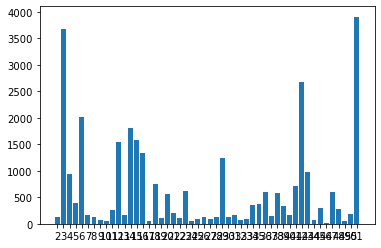

In [19]:
truecol = pandasDF.groupby('sur_velo').head()
truecol = pandasDF.loc[pandasDF.sur_velo == True]
datas = truecol.groupby('id').count()
groups = datas.to_dict()
keys = groups['timestamp'].keys()
values = datas['timestamp'].to_dict().values
plt.bar(range(len(groups['timestamp'])), list(groups['timestamp'].values()), align='center')
plt.xticks(range(len(groups['timestamp'])), list(groups['timestamp'].keys()))
plt.show()

2) Réalisez un graphique en barre qui affiche le temps de chaque trajet d'un cycliste. Faites en sorte qu'on puisse choisir un id et afficher les trajets de cet id.

## 6) Sauvegarde

Sauvegardez votre dataset trajets au format csv dans le dossier data.

In [ ]:
pandasDF.to_csv('./test.csv')